<a href="https://colab.research.google.com/github/hyesunyun/ngram-language-model-lab/blob/main/n_gram_word_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# N-gram language model for word prediction

*Adapted from https://github.com/TrishamBP/autocomplete-n-gram-language-model & https://www.kaggle.com/code/sauravmaheshkar/auto-completion-using-n-gram-models*

In this lab, we will implement and evaluate N-gram language models for word prediction using natural language processing techniques. The model is trained on a corpus of Twitter data and employs various N-gram orders (from unigrams to 4-grams) to predict the next word in a given sequence.

We also explore the effectiveness of common smoothing technique, additive (Laplace) smoothing, to handle the challenge of unseen N-grams.

## Introduction: N-grams are the building blocks of language modeling

Language modeling is a fundamental task in natural language processing with applications ranging from speech recognition to machine translation. N-gram models serve as the fundamental building blocks of language modeling. N-grams are probabilistic language models that estimate the likelihood of a word based on the preceding N-1 words. In other words, they model the conditional probability of a word given its context.

**The Essence of N-grams**
- **Definition**: An N-gram is a contiguous sequence of N items (words, characters, or other tokens) from a given sample of text or speech.

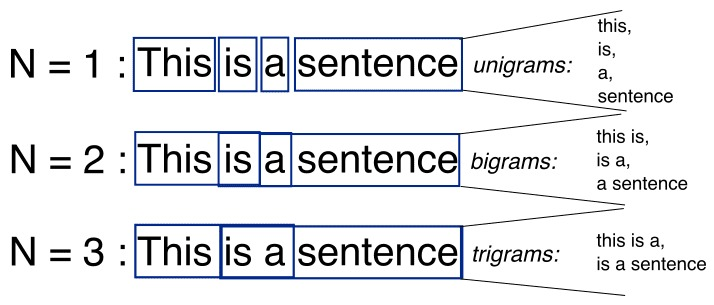

## Theoretical Background

### N-gram Language Models
An N-gram is a contiguous sequence of N items from a given text. In the context of language modeling, these items are typically words. The N-gram model approximates the probability of a word given its history by considering only the `n` previous words.

For instance if $w_{1:n}$ represents the sequence of words $w_1 w_2...w_n$, then using the chain rule of probability we can write,

$$
P(w_{1:n}) = P(w_1)P(w_2|w_1)P(w_3|w_{1:2})...P(w_n|w_{1:n-1})\\
P(w_{1:n}) = \prod_{k=1}^{n}P(w_k|w_{1:k-1})
$$

A Bigram Model corresponds to a model which approximates the probability of a word given all the previous words $P(w_{n}|w_{1:n-1})$ by using only the conditional probability of the preceding word $P(w_n|w_{n-1})$. Thus we assume that $P(w_n|w_{1:n-1}) \approx P(w_n|w_{n-1}1)$. This approximation is known as the Markov approximation.

$$P(w_{1:n})\approx\prod_{k=1}^{n}p(w_k|w_{𝑘−1})$$

**Estimation**

To estimate such probabilities, we use the Maximum Likelihood Estimation (MLE). An MLE estimate for the parameters of an N-gram model can be obtained by getting counts from a corpus, and normalizing the counts so that they lie between 0 and 1.

For a Bigram model, the MLE Estimation can be given by:

$$P(w_n | w_{n-1}) = \frac{C(w_{n-1}w_n)}{\sum_{w} C(w_{n-1}w)}$$

For the general case of MLE N-gram parameter estimation:
$$P(w_n|w_{n−N+1:n−1})=\frac{C(w_{n-N+1:n-1}w_n)}{C(w_{n−N+1:n−1})}$$

### Smoothing
Smoothing techniques address the issue of zero probabilities for unseen N-grams. This project implements additive (Laplace) smoothing, which adds a small constant k to all count values:

$$P(w_n|w_{n−N+1:n−1}) = \frac{C(w_{n−N+1:n−1}w_n) + k}{C(w_{n−N+1:n−1}) + k |V|}$$

where |V| is the vocabulary size.

### Perplexity
Perplexity is used as an intrinsic evaluation metric often used for language models. It is defined as:

$$PP(W) = P(w_1, w_2, ..., w_N)^{-\frac{1}{N}}$$

where W is a sequence of N words. Lower perplexity indicates better model performance.



## Basic Setup

Import packages needed to implement N-gram models from scratch.
We will use numpy and nltk (for tokenization).

In [ ]:
## Importing Packages
import math
import nltk
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

## Basic File Paths
data_dir = "./data"
file_path = data_dir + "/en_US.twitter.txt"

## nltk settings
nltk.data.path.append(data_dir)
nltk.download('punkt')
nltk.download('punkt_tab')

## Opening the data file in read mode ("r")
with open(file_path, "r") as f:
    data = f.read()

## Pre-processing pipeline

We create a simple pipeline function which:
- splits the datasets by the \n character
- remove leading and trailing spaces
- drop empty sentences
- convert to lowercase and tokenize sentences using `nltk.word_tokenize`

In [ ]:
def preprocess_pipeline(data: str) -> list:
    """
    Preprocesses the input text data by performing the following steps:
    1. Splits the data into sentences using newline characters.
    2. Removes leading and trailing spaces from each sentence.
    3. Drops empty sentences.
    4. Converts each sentence to lowercase.
    5. Tokenizes each sentence into words using NLTK's word_tokenize function.

    Args:
        data (str): The input text data to be preprocessed.

    Returns:
        list: A list of tokenized sentences, where each sentence is represented as a list of words.
    """

    # Split by newline character
    sentences = data.split('\n')

    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]

    # Drop Empty Sentences
    sentences = [s for s in sentences if len(s) > 0]

    # Empty List to hold Tokenized Sentences
    tokenized = []

    # Iterate through sentences
    for sentence in sentences:
        ##### IMPLEMENT THE FOLLOWING STEPS: #####

        # Convert to lowercase

        # Convert to a list of words by calling nltk.word_tokenize(sentence)

        # Append to list

    return tokenized

## Pass our data to this function
tokenized_sentences = preprocess_pipeline(data)

## Splitting into Train and Test

In [ ]:
## Obtain Train and Test Split
train, test = train_test_split(tokenized_sentences, test_size=0.2, random_state=42)

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

## Cleaning the Data

### Creating a Frequency Dictionary

As our dataset is quite big, we'll only use those words that appear k times in our dataset. In this function, we'll create a frequency dictionary for our vocabulary.

In [ ]:
def count_the_words(sentences: list[list[str]]) -> dict[str, int]:
  """
  Count the occurrences of each word in a list of sentences.

  Args:
    sentences (list[list[str]]): A list of sentences, where each sentence is represented as a list of words (strings).

  Returns:
    dict[str, int]: A dictionary where keys are words and values are the counts of those words in the input sentences.

  Example:
    >>> sentences = [["hello", "world"], ["hello", "python"]]
    >>> count_the_words(sentences)
    {'hello': 2, 'world': 1, 'python': 1}
  """

  # Creating a Dictionary of counts
  word_counts = {}

  ##### IMPLEMENT THE FOLLOWING STEPS: #####

  # Iterating over sentences

    # Iterating over tokens for each sentence

      # Add count for new word if token exists in word_counts dictionary as key
      # Increase count by one if token already exists in word_counts dictionary

  return word_counts

### Creating a Closed Vocabulary

One of the most essential steps in dealing with textual data is handling out-of-vocabulary (OOV) words. This helps the model to handle words which are not present in the training corpus. First step in this process is to create a `closed_vocabulary`. This function creates a closed vocabulary containing only those words according to the `count_threshold` parameter.

In [ ]:
def handling_oov(tokenized_sentences: list[list[str]], count_threshold: int) -> list[str]:
  """
  Handles out-of-vocabulary (OOV) words by creating a closed vocabulary list based on a frequency threshold.

  Args:
    tokenized_sentences (list[list[str]]): A list of tokenized sentences, where each sentence is represented as a list of words.
    count_threshold (int): The minimum frequency a word must have to be included in the closed vocabulary.

  Returns:
    list[str]: A list of words that meet or exceed the frequency threshold.
  """

  # Empty list for closed vocabulary
  closed_vocabulary = []

  # Obtain frequency dictionary using previously defined function
  words_count = count_the_words(tokenized_sentences)

  # Iterate over words and counts
  for word, count in words_count.items():

    # Append if it's more (or equal) to the threshold
    if count >= count_threshold:
      closed_vocabulary.append(word)

  return closed_vocabulary

### Adding UNK Tokens

In this function we'll add `<unk>` tokens, to those words which are not in the `closed_vocabulary` which we just made.

In [ ]:
def unk_tokenize(tokenized_sentences: list[list[str]], vocabulary: list[str], unknown_token: str = "<unk>") -> list[list[str]]:
  """
  Replace tokens in sentences that are not in the vocabulary with an unknown token.

  Args:
    tokenized_sentences (list[list[str]]): A list of tokenized sentences, where each sentence is a list of tokens (strings).
    vocabulary (list[str]): A list of known tokens (strings) that are considered part of the vocabulary.
    unknown_token (str, optional): The token to use for unknown words. Defaults to "<unk>".

  Returns:
    list[list[str]]: A list of tokenized sentences with unknown tokens replaced by the specified unknown token.
  """

  # Convert Vocabulary into a set
  vocabulary = set(vocabulary)

  # Create empty list for sentences
  new_tokenized_sentences = []

  # Iterate over sentences
  for sentence in tokenized_sentences:

    # Iterate over sentence and add <unk>
    new_sentence = []
    for token in sentence:
      ##### IMPLEMENT THE FOLLOWING STEPS: #####
      # if the token is absent from the vocabulary replace the token with the <unk> token
      # else add the original token to the new sentence

    # Append sentence to the new list
    new_tokenized_sentences.append(new_sentence)

  return new_tokenized_sentences

### Final Cleaning Pipeline

In [ ]:
def cleansing(train_data: list, test_data: list, count_threshold: int) -> tuple[list, list, list]:
  """
  Cleanses the training and test datasets by handling out-of-vocabulary (OOV) words and tokenizing them.

  Args:
    train_data (list): The training dataset, a list of sentences or words.
    test_data (list): The test dataset, a list of sentences or words.
    count_threshold (int): The minimum frequency count for a word to be included in the vocabulary.

  Returns:
    tuple[list, list, list]: A tuple containing:
      - new_train_data (list): The updated training dataset with OOV words replaced by a special token.
      - new_test_data (list): The updated test dataset with OOV words replaced by a special token.
      - vocabulary (list): The list of words that meet the count threshold.
  """
  ##### IMPLEMENT THE FOLLOWING STEPS: #####
  # Get closed vocabulary using handling_oov function
  # Update Training Dataset using unk_tokenize function
  # Update Test Dataset using unk_tokenize function

  return new_train_data, new_test_data, vocabulary

In [ ]:
# choose the threshold for minimum frequency
min_freq = 4

# call final cleaning pipeline for both train and test
final_train, final_test, vocabulary = cleansing(train, test, min_freq)

## Building The "Model"

This is a helper function, which will come in handy during inference. This function returns a mapping from N-grams to their frequency in the dataset.

In [ ]:
def count_n_grams(data: list[list[str]], n: int, start_token: str = "<s>", end_token: str = "<e>") -> dict[tuple[str, ...], int]:
  """
  Count the occurrences of n-grams in a given dataset of sentences.

  Args:
    data (list[list[str]]): A list of sentences, where each sentence is represented as a list of words.
    n (int): The number of words in each n-gram.
    start_token (str, optional): The token to prepend to the beginning of each sentence. Defaults to "<s>".
    end_token (str, optional): The token to append to the end of each sentence. Defaults to "<e>".

  Returns:
    dict[tuple[str, ...], int]: A dictionary where the keys are n-grams (represented as tuples of strings) and the values are the counts of those n-grams in the dataset.
  """

  # Empty dict for n-grams
  n_grams = {}

  # Iterate over all sentences in the dataset
  for sentence in data:

    # Append n start tokens and a single end token to the sentence
    sentence = [start_token]*n + sentence + [end_token]

    # Convert the sentence into a tuple
    sentence = tuple(sentence)

    # Temp variable to store length from start of n-gram to end
    m = len(sentence) if n == 1 else len(sentence) - 1

    # Iterate over this temp variable for length and count the n-grams
    for i in range(m):

      # Get the n-gram
      n_gram = sentence[i:i+n]

      # Add the count of n-gram as value to our dictionary
      # IF n-gram is already present
      if n_gram in n_grams.keys():
        n_grams[n_gram] += 1
      # Add n-gram count
      else:
        n_grams[n_gram] = 1

  return n_grams

This function calculates the priority for the next word given the prior N-gram. This function also implements k-smoothing which helps account for unseen N-grams.

$$P(w_n|w_{n−N+1:n−1}) = \frac{C(w_{n−N+1:n−1}w_n) + k}{C(w_{n−N+1:n−1}) + k |V|}$$

In [ ]:
def prob_for_single_word(word: str, previous_n_gram: tuple[str, ...], n_gram_counts: dict[tuple[str, ...], int],
                        nplus1_gram_counts: dict[tuple[str, ...], int], vocabulary_size: int, k: float = 1.0) -> float:
    """
    Calculate the probability of a word given the previous n-gram using Laplace smoothing.

    Args:
        word (str): The word for which we want to calculate the probability.
        previous_n_gram (tuple[str, ...]): The previous n-gram as a tuple of strings.
        n_gram_counts (dict[tuple[str, ...], int]): A dictionary containing counts of n-grams.
        nplus1_gram_counts (dict[tuple[str, ...], int]): A dictionary containing counts of (n+1)-grams.
        vocabulary_size (int): The size of the vocabulary.
        k (float, optional): The smoothing parameter. Defaults to 1.0.

    Returns:
        float: The probability of the word given the previous n-gram.
    """
    # Calculating the count, if exists from our freq dictionary otherwise zero
    previous_n_gram_count = n_gram_counts[previous_n_gram] if previous_n_gram in n_gram_counts else 0

    # previous n-gram plus the current word as a tuple
    nplus1_gram = previous_n_gram + (word,)

    # Calculating the nplus1 count, if exists from our freq dictionary otherwise zero
    nplus1_gram_count = nplus1_gram_counts[nplus1_gram] if nplus1_gram in nplus1_gram_counts else 0

    ##### IMPLEMENT THE FOLLOWING STEPS: #####
    # calculate the probability using the formula for Laplace smoothing
    # HINT: Refer to the formula in the text above
    ## calculate the denominator using the count of the previous n gram & smoothing
    ## calculate the numerator using the count of the n plus 1 gram & smoothing
    ## get the probability using the numerator and denominator

    return prob

Now, we loop over all the words in the vocabulary and then compute their probabilites using our `prob_for_single_word()` function.

In [ ]:
def probs(previous_n_gram: list[str], n_gram_counts: dict[tuple[str, ...], int],
          nplus1_gram_counts: dict[tuple[str, ...], int], vocabulary: list[str], k: float = 1.0) -> dict[str, float]:
  """
  Calculate the probabilities of each word in the vocabulary given the previous n-gram.

  Args:
    previous_n_gram (list[str]): The previous n-gram as a list of strings.
    n_gram_counts (dict[tuple[str, ...], int]): A dictionary of n-gram counts.
    nplus1_gram_counts (dict[tuple[str, ...], int]): A dictionary of (n+1)-gram counts.
    vocabulary (list[str]): A list of words in the vocabulary.
    k (float, optional): Smoothing parameter. Defaults to 1.0.

  Returns:
    dict[str, float]: A dictionary mapping each word in the vocabulary to its probability.
  """

  # Convert to Tuple
  previous_n_gram = tuple(previous_n_gram)

  # Add end and unknown tokens to the vocabulary
  vocabulary = vocabulary + ["<e>", "<unk>"]

  # Calculate the size of the vocabulary
  vocabulary_size = len(vocabulary)

  # Empty dict for probabilites
  probabilities = {}

  ##### IMPLEMENT THE FOLLOWING STEPS: #####
  # Iterate over each word in vocabulary and calculate the probability
  # HINT: Use prob_for_single_word function to calculate the probability for each word
  # Create mapping: word -> probability in the probabilities dictionary

  return probabilities

## The Auto-Complete System

Finally, we build our `auto_complete` function. We simply loop over all the words in the vocabulary assuming that they can be the next word and then return the word with it's probability.

In [ ]:
def auto_complete(previous_tokens: list[str], n_gram_counts: dict[tuple[str, ...], int],
                  nplus1_gram_counts: dict[tuple[str, ...], int], vocabulary: list[str],
                  k: float = 1.0, start_with: str = None) -> tuple[str, float]:
    """
    Predicts the next word in a sequence based on n-gram and (n+1)-gram counts.

    Args:
        previous_tokens (list[str]): A list of previous words in the sequence.
        n_gram_counts (dict[tuple[str, ...], int]): A dictionary of n-gram counts.
        nplus1_gram_counts (dict[tuple[str, ...], int]): A dictionary of (n+1)-gram counts.
        vocabulary (list[str]): A list of all possible words in the vocabulary.
        k (float, optional): Smoothing parameter. Defaults to 1.0.
        start_with (str, optional): If provided, the predicted word must start with this substring. Defaults to None.

    Returns:
        tuple[str, float]: A tuple containing the suggested next word and its probability.
    """

    # length of previous words
    n = len(list(n_gram_counts.keys())[0])

    # most recent 'n' words
    previous_n_gram = previous_tokens[-n:]

    # Calculate probabilty for all words
    probabilities = probs(previous_n_gram, n_gram_counts, nplus1_gram_counts, vocabulary, k=k)

    # Intialize the suggestion and max probability
    suggestion = None
    max_prob = 0

    # Iterate over all words and probabilites, returning the max.
    # We also add a check if the start_with parameter is provided
    for word, prob in probabilities.items():

        if start_with is not None:
            if not word.startswith(start_with):
                continue

        if prob > max_prob:
            suggestion = word
            max_prob = prob

    return suggestion, max_prob

We can also loop over all the various n-gram models to get multiple suggestions. This function just extends from the previously defined function by **taking multiple N-gram counts** instead of one. This allows us to take unigram, bigram, ... counts into account as well.

In [ ]:
def get_suggestions(previous_tokens: list[str], n_gram_counts_list: list[dict[tuple[str, ...], int]], vocabulary: list[str], k: float = 1.0, start_with: str = None) -> list[tuple[str, float]]:
    """
    Generate a list of word suggestions based on previous tokens using n-gram language models.
    Args:
        previous_tokens (list[str]): A list of tokens (words) preceding the current position.
        n_gram_counts_list (list[dict[tuple[str, ...], int]]): A list of dictionaries containing n-gram counts.
            Each dictionary corresponds to a different n-gram model.
        vocabulary (list[str]): A list of all possible words in the vocabulary.
        k (float, optional): Smoothing parameter to avoid zero probabilities. Defaults to 1.0.
        start_with (str, optional): If provided, only suggestions starting with this string will be considered. Defaults to None.
    Returns:
        list[tuple[str, float]]: A list of tuples where each tuple contains a suggested word and its corresponding probability.
    """

    # See how many models we have
    model_counts = len(n_gram_counts_list)

    # Empty list for suggestions
    suggestions = []

    # Loop over counts
    for i in range(model_counts-1):

        # get n and nplus1 counts
        n_gram_counts = n_gram_counts_list[i]
        nplus1_gram_counts = n_gram_counts_list[i+1]

        # get suggestions
        suggestion = auto_complete(previous_tokens, n_gram_counts,
                                    nplus1_gram_counts, vocabulary,
                                    k=k, start_with=start_with)
        # Append to list
        suggestions.append(suggestion)

    return suggestions

## Inference

In [ ]:
# Pre-trained n-gram counts from final_train
n_gram_counts_list = []
for n in range(1, 5):  # Unigram to 4-gram
    n_gram_counts = count_n_grams(final_train, n)
    n_gram_counts_list.append(n_gram_counts)

In [ ]:
## Autocomplete based on user input
def get_user_input_suggestions(vocabulary: list[str], n_gram_counts_list: list[dict[tuple[str, ...], int]], k: float = 1.0) -> None:
    """
    Interactively prompts the user to enter a sentence and provides word suggestions based on n-gram language model.

    Args:
        vocabulary (list[str]): A list of words in the vocabulary.
        n_gram_counts_list (list[dict[tuple[str, ...], int]]): A list of dictionaries containing n-gram counts.
        k (float, optional): Smoothing parameter for probability calculation. Defaults to 1.0.

    Returns:
        None

    The function continuously prompts the user to enter a sentence until 'q' is entered to quit.
    It tokenizes the user input, generates word suggestions based on the n-gram model, sorts the suggestions
    by their probabilities in descending order, and prints the suggestions with their probabilities.
    """
    while True:
        user_input = input("Enter a sentence (or 'q' to quit): ").lower().strip()
        if user_input == 'q':
            break

        # Tokenize the user input
        tokens = nltk.word_tokenize(user_input)

        # Get suggestions
        suggestions = get_suggestions(tokens, n_gram_counts_list, vocabulary, k)

        # Sort suggestions by probability (highest first) and print them
        sorted_suggestions = sorted(suggestions, key=lambda x: x[1], reverse=True)

        print("\nSuggestions:")
        for i, (word, prob) in enumerate(sorted_suggestions, 1):
            print(f"{i}. {word} (probability: {prob:.6f})")

        print("\n")

In [ ]:
# Call the function
get_user_input_suggestions(vocabulary, n_gram_counts_list)

## Evaluation

In [ ]:
# Let's see how many n-grams we have in our corpus.
print("unigram count:" , len(n_gram_counts_list[0]))
print("bigram count:", len(n_gram_counts_list[1]))
print("trigram count:", len(n_gram_counts_list[2]))
print("quadgram count:", len(n_gram_counts_list[3]))

Calculate the perplexity for a sentence given an n-gram model by following the formula:
$$PP(W) = P(w_1, w_2, ..., w_N)^{-\frac{1}{N}}$$

The join probability $P(w_1, w_2, ..., w_N)$ can be computed as:
$$P(w_1, w_2, ..., w_N) = \prod_{i=1}^{N} P(w_i|w_{<i})$$
where $P(w_i|w_{<i})$ is the probability of each word given its history.


In [ ]:
# Function calculates perplexity which is used as an evaluation metric for our model
def calculate_perplexity(sentence: list[str], n_gram_counts: dict[tuple[str, ...], int],
                         nplus1_gram_counts: dict[tuple[str, ...], int], vocabulary_size: int,
                         start_token: str = '<s>', end_token: str = '<e>', k: float = 1.0) -> float:
    """
    Calculate the perplexity of a given sentence using n-gram and (n+1)-gram counts.

    Args:
        sentence (list[str]): The input sentence as a list of words.
        n_gram_counts (dict[tuple[str, ...], int]): Dictionary of n-gram counts.
        nplus1_gram_counts (dict[tuple[str, ...], int]): Dictionary of (n+1)-gram counts.
        vocabulary_size (int): The size of the vocabulary.
        start_token (str, optional): The token representing the start of a sentence. Defaults to '<s>'.
        end_token (str, optional): The token representing the end of a sentence. Defaults to '<e>'.
        k (float, optional): Smoothing parameter. Defaults to 1.0.

    Returns:
        float: The perplexity of the sentence.
    """

    # length of previous words
    n = len(list(n_gram_counts.keys())[0])

    # prepend <s> and append <e>
    sentence = [start_token] * n + sentence + [end_token]

    # Cast the sentence from a list to a tuple
    sentence = tuple(sentence)

    # length of sentence (after adding <s> and <e> tokens)
    N = len(sentence)

    # calculate the product of the probabilities of each word in the sentence
    joint_probability = 1.0

    # Index t ranges from n to N - 1, inclusive on both ends
    # This is so that we can consider the n-gram preceding each word
    for t in range(n, N):
        ##### IMPLEMENT THE FOLLOWING STEPS: #####
        # Get the n-gram preceding the word at position t
        # Get the word at position t
        # Estimate the probability of the word at position t in the context of n-gram preceding the word at position t
        # Update the product of the joint_probability

    # Finally, calculate the perplexity given the joint probability (HINT: exponent in the formula)

    return perplexity

In [ ]:
def calculate_perplexities_for_test_data(final_test: list[list[str]], n_gram_counts_list: list[dict[tuple[str, ...], int]],
                                         vocabulary_size: int, start_token: str = '<s>', end_token: str = '<e>', k: float = 1.0) -> list[float]:
    """
    Calculate the perplexities for test data using n-gram language models.

    Args:
        final_test (list[list[str]]): A list of sentences, where each sentence is represented as a list of words.
        n_gram_counts_list (list[dict[tuple[str, ...], int]]): A list of dictionaries containing n-gram counts for different n-gram models.
        vocabulary_size (int): The size of the vocabulary used in the language model.
        start_token (str, optional): The token representing the start of a sentence. Defaults to '<s>'.
        end_token (str, optional): The token representing the end of a sentence. Defaults to '<e>'.
        k (float, optional): The smoothing parameter. Defaults to 1.0.

    Returns:
        list[float]: A list of average perplexities for each n-gram model from unigram to 4-gram.
    """

    perplexities = []

    # See how many models we have
    model_counts = len(n_gram_counts_list)

    for n in range(1, 5):  # Unigram to 4-gram
        print(f"Calculating perplexity for {n}-gram model...")

        # Get n-gram and (n+1)-gram counts from training data
        n_gram_counts = n_gram_counts_list[n-1]  # n-gram counts
        nplus1_gram_counts = n_gram_counts_list[n] if n < 4 else {}  # (n+1)-gram counts, empty for 4-gram

        # Calculate perplexity for each sentence in final_test
        model_perplexities = []
        for sentence in final_test:
            perplexity = calculate_perplexity(sentence, n_gram_counts, nplus1_gram_counts, vocabulary_size, start_token, end_token, k)
            model_perplexities.append(perplexity)

        # Average perplexity for this model
        average_perplexity = sum(model_perplexities) / len(model_perplexities)
        perplexities.append(average_perplexity)
        print(average_perplexity)

    return perplexities

In [ ]:
# Vocabulary size of train data
# Add end and unknown tokens to the vocabulary
vocabulary = vocabulary + ["<e>", "<unk>"]

# Calculate the size of the vocabulary
vocabulary_size = len(vocabulary)

# Calculate perplexities using test data - This may take few minutes to finish running
perplexities = calculate_perplexities_for_test_data(final_test, n_gram_counts_list, vocabulary_size)

# Display results
for i, perplexity in enumerate(perplexities):
    print(f"{i+1} Perplexity: {perplexity}")

Analyze the overlap between N-grams in the training and test datasets. A high proportion of unseen N-grams indicates a need for more training data or better smoothing. The helper function below can check the proportion of unseen N-grams in the test data for each N-gram size.

A high unseen ratio (e.g., >50%) indicates a sparsity problem.

Adding advanced smoothing or backoff methods should decrease the perplexity for higher N-grams or at least stabilize, reflecting improved generalization.

In [ ]:
def unseen_ngram_ratio(test_data: list[list[str]], n: int, n_gram_counts: dict[tuple[str, ...], int]) -> float:
    """
    Calculate the ratio of unseen n-grams in the test data.

    This function computes the proportion of n-grams in the test data that do not appear in the provided n-gram counts.

    Args:
        test_data (list[list[str]]): A list of sentences, where each sentence is represented as a list of words.
        n (int): The size of the n-grams to be considered.
        n_gram_counts (dict[tuple[str, ...], int]): A dictionary containing n-gram counts, where keys are n-grams (tuples of strings) and values are their counts.

    Returns:
        float: The ratio of unseen n-grams to the total number of n-grams in the test data.
    """
    unseen_count = 0
    total_count = 0

    for sentence in test_data:
        # get all the n_grams for the given n
        n_grams = [tuple(sentence[i:i+n]) for i in range(len(sentence) - n + 1)]
        for n_gram in n_grams:
            # get total count of n_grams
            total_count += 1
            # increment unseen count if not in n_gram_counts
            if n_gram not in n_gram_counts:
                unseen_count += 1

    return unseen_count / total_count

In [ ]:
for n in range(1, 5):  # Unigram to 4-gram
    unseen_ratio = unseen_ngram_ratio(final_test, n, n_gram_counts_list[n-1])
    print(f"{n}-gram unseen ratio: {unseen_ratio:.2%}")


## Takeways

**Advantages of N-grams**
- **Simplicity**: N-grams are intuitive and relatively simple to understand and implement.
- **Low Memory Usage**: They require minimal memory for storage compared to more complex models.

**Limitations of N-grams**
- **Limited Context**: N-grams have a finite context window, which means they cannot capture long-range dependencies or context beyond the previous N-1 words.
- **Sparsity**: As N increases, the number of possible N-grams grows exponentially, leading to sparse data and increased computational demands.